## Example: Geostatistical regression application

In this notebook we provide an example which finds the optimal design for the geostatistical regression model using stochastic gradient descent (SGD).

#### Data Model

In this section we consider a geostatistic regression model using 2 dimensions. We wish to search for $n$ coordinates where observations should be made to maximise the utility function.

Here we consider a model which assumes normal observations with a linear trend and squared exponential covariance function with a nugget effect.

$$
\begin{align*}
y &\sim N_m(x(\theta, \tau), \Sigma(\tau)), \\
x_i &= \theta_1 \tau_{i1} + \theta_2 \tau_{i2}, \\
\Sigma &= \sigma_1^2 I + \sigma_2^2 R(\tau) \\
R_{ij} &= \exp \bigg[-\sum_{k=1}^2 (\tau_{ik} - \tau_{jk})^2 / \ell^2 \bigg]
\end{align*}
$$

For simplicity we assume that $\sigma_1, \sigma_2$ (observation variance components) and $\ell$ (covariance length scale) are known, and the unknown parameters are $\theta_1$ and $\theta_2$ (trends).

We define an alternative parameterisation by setting $\kappa = \sigma_1^2 + \sigma_2^2$ and $\gamma = \frac{\sigma_1^2}{\sigma_1^2 + \sigma_2^2}$ yielding $\Sigma = \kappa [\gamma I + (1-\gamma) R]$.

#### Utility Function

In this illustration we use the fisher information gain (FIG) as the chosen utility function. This quantifies how much is leaned about the parameter of interest at a given design time.

For the geostatistical model the FIG is given by

$$
\text{tr} \mathcal{I}(\tau)
= \sum_{i=1}^d \tau_i^T \Sigma(\tau)^{-1} \tau_i,
$$

Note this does not depend on $\theta$ and so $U_{FIG}(\tau) = \text{tr} \mathcal{I}(\tau)$ can be calculated exactly.

Also note that $\kappa$ only affects $U_{FIG}$ as a constant of proportionality, so it does not change the optimal design.

#### Using SGD to target the optimal design

Here we use the Tensorflow module to implement a SGD algorithm on the loss function (negated utility function) searching over the design space. Any SGD method can be applied; here we use the adaptive moment estimation (Adam).

## Implementation using Tensorflow

First import the dependencies.

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

Define the constants. Here we randomly generate the initial state uniformly over the search space $\big[-\frac{1}{2}, \frac{1}{2} \big]^2$.

In [3]:
nsensors = 100 #set the number of sensors to use (i.e. number of coordinates at which to make observations)

initial_design = np.random.uniform(low=-0.5, high=0.5, size=[nsensors, 2]) #sample an initial state

# use the sampled initial_design as the value to initialise the design at
design = tf.Variable(tf.constant(initial_design, dtype=tf.float32))

We now set the values for $\ell$ and $\gamma$.

In [4]:
l = np.sqrt(0.001)  #length scale
gam = 0.1 #weighting between additive error and correlation between observations

Next we define the model and FIG using Tensorflow. Note that we are using a descent algorithm rather than an ascent algorithm hence by default this will minimise the objective function. Thus the loss function, defined the negated utility function, is used as the objective function here.

In [5]:
# define a function to compute the squared differences between the observations
def squared_diff(A):
    r = tf.reduce_sum(A*A, 1)
    r = tf.reshape(r, [-1, 1])
    return r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)

# compute the squared differences
norms_mat = squared_diff(design)
#correlation is squared exponential
cor = tf.exp(-norms_mat / l**2.)

# calculate covariance matrix
Sigma = tf.constant(gam) * tf.diag(np.ones(nsensors, dtype=np.float32)) + (1-tf.constant(gam))*cor
#compute inverse
Sigma_inv = tf.matrix_inverse(Sigma)

# compute FIG
fig = tf.trace(tf.matmul(design, tf.matmul(Sigma_inv, design), transpose_a=True))
# compute the (unpenalised) loss function (-FIG), based on only 1 estimate being used in MC estimate
loss_nopen = -fig

Need to define a penalty function to ensure observations are within the search space.

In [6]:
# function to penalise design times above a set threshold
def maxthrespen(th, thres, k = 10000.):
    with tf.name_scope("maxthrespen"):
        max_des = tf.reduce_max(th)
        over_thres = tf.maximum(max_des - thres, 0.0)
        out = k * over_thres
    return out

# function to penalise design times above a set threshold
def minthrespen(th, thres, k = 10000.):
    with tf.name_scope("minthrespen"):
        min_des = tf.reduce_min(th)
        over_thres = tf.minimum(min_des - thres, 0.0)
        out = -1.0 * k * over_thres
    return out

# add penalties for any observations outside unit square centered at the origin
pen = minthrespen(design, thres = -0.5, k=100.) + maxthrespen(design, thres = 0.5, k=100.)

# overall loss function with penalties added
loss = loss_nopen + pen

Next, we define the optimiser and initialise the global variables.

In [7]:
optimiser = tf.train.AdamOptimizer()
train = optimiser.minimize(loss, var_list = [design])
init = tf.global_variables_initializer()

We can now run the stochastic optimisation for a set number of iterations. Here we will use $2 \times 10^3$ iterations.

In [8]:
# split the iterations into blocks so that it is easy to include a convergence criterion
# also reduces memory required if lots of iterations are required
nloops = 200
its_per_loop = 10

iterations = np.zeros(nloops)
designs = np.zeros([nloops, nsensors, 2])
losses = np.zeros(nloops)
with tf.Session() as sess:
    sess.run(init)
    for i in range(nloops):
        mean_loss = 0.
        for j in range(its_per_loop):
            next_loss, next_design, Sig, _ = sess.run([loss_nopen, design, Sigma, train])
            mean_loss += next_loss
        mean_loss /= its_per_loop
        print("Current loop: {:3d}  Current utility: {:.3f}".format(i, -1.* mean_loss), end="\r")
        iterations[i] = i*its_per_loop
        designs[i, :, :] = next_design
        losses[i] = mean_loss
        mean_loss = 0.

Now we can make plots of the output.

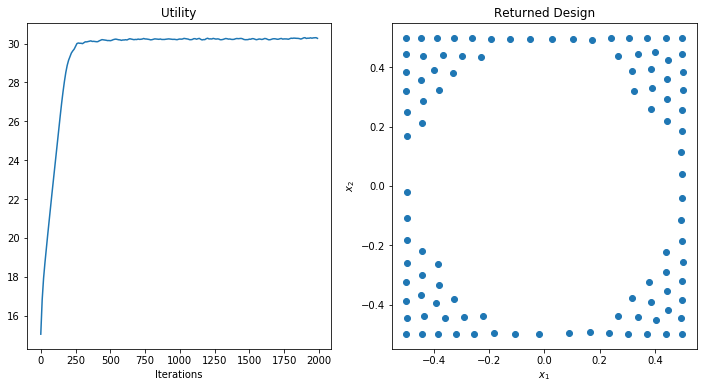

In [9]:
fig = plt.figure()
fig.set_size_inches(12,6)

# plot the trace of the utility
plt.subplot(1,2,1)
plt.plot(iterations,-losses); plt.title('Utility') # utility = -1 * loss
plt.xlabel('Iterations')

# plot the trace of the design
plt.subplot(1,2,2)
plt.plot(designs[nloops-1,:,0], designs[nloops-1,:,1], "o")
plt.title('Returned Design')
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')

plt.show()